# Projet 6 : Classifiez automatiquement des biens de consommation.

## Faisabilité de classification automatique des images / technique avancée

* [1. Contexte](#partie1)
* [2. Préparation de l'environnement](#partie2)
    * [2.1 Préparation des données](#partie2.1)
    * [2.2 Répertoire des fonctions](#partie2.2)
* [3. Prétraitement des images](#partie3)
* [4. Extraction des features avec CNN Transfer Learning](#partie4)
* [5. Conclusion](#partie5)

## <font color='red'>1. Contexte</font><a class="anchor" id="partie1"></a>

Ce livrable vise à appliquer une technique plus avancée de reconnaissance d'images en utilisant des réseaux de neurones convolutifs (CNN) et la technique du Transfer Learning. L'idée est de vérifier si l'utilisation de modèles pré-entraînés sur de larges ensembles de données, tels que VGG16, permet de classer automatiquement les produits en fonction de leurs images.

Les principales étapes de ce livrable sont :

- Prétraitement des images : Redimensionnement et normalisation des images pour qu'elles correspondent aux dimensions requises par le modèle VGG16.
- Transfer Learning avec VGG16 : Utilisation du modèle VGG16 pré-entraîné sur le dataset ImageNet. Ce modèle est adapté aux besoins de notre classification en ajoutant des couches fully connected pour prédire les catégories des produits.
- Réduction de dimension et visualisation : Projection des caractéristiques extraites par VGG16 en 2D via T-SNE pour observer la séparation visuelle des différentes catégories.
- Évaluation des clusters : Application de l'algorithme K-Means pour regrouper les images en clusters et évaluation avec l'ARI.

Ce livrable vise à démontrer la puissance des CNN et du Transfer Learning pour la classification automatique des images, comparée aux méthodes plus traditionnelles comme SIFT.

## <font color='red'>2. Préparation de l'environnement</font><a class="anchor" id="partie2"></a>

### <font color='purple'>Préparation des données</font>

In [ ]:
!pip install tensorflow

In [ ]:
import os
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import time
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Charger le fichier CSV dans un data frame
df = pd.read_csv('/content/drive/My Drive/projet_6/df_classification_copy.csv')

In [ ]:
# Définir le chemin de base des images
chemin_images = '/content/drive/My Drive/projet_6/Images/'

## <font color='red'>3. Prétraitement des images</font><a class="anchor" id="partie3"></a>

In [ ]:
# Liste des extensions d'images supportées
extensions_supportees = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

def charger_images(chemin):
    """
    Charge toutes les images d'un répertoire donné.

    Args:
        chemin (str): Chemin vers le répertoire des images.

    Returns:
        dict: Dictionnaire contenant les noms des fichiers et les images chargées.
    """
    images = {}
    for fichier in os.listdir(chemin):
        if fichier.lower().endswith(extensions_supportees):
            chemin_complet = os.path.join(chemin, fichier)
            image = cv2.imread(chemin_complet)
            if image is not None:
                images[fichier] = image
            else:
                print(f"Erreur de chargement pour l'image : {fichier}")
    return images

# Charger les images brutes
images_brutes = charger_images(chemin_images)
print(f"Nombre d'images chargées : {len(images_brutes)}")

Nombre d'images chargées : 1050


## <font color='red'>4. Extraction des features avec CNN Transfer Learning</font><a class="anchor" id="partie4"></a>

### <font color='purple'> Chargement du modèle VGG16</font>

In [ ]:
# Charger le modèle VGG16 pré-entraîné avec les couches jusqu'à fc2
base_model = VGG16(weights='imagenet')
model_vgg16 = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Afficher le résumé du modèle
print(model_vgg16.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### <font color='purple'> Extraction des features</font>

In [ ]:
# Extraire les features de toutes les images brutes
features_vgg16 = []
i = 0
for nom, image_path in df['image'].items():  # df['image'] contient les noms des images
    if i % 100 == 0:
        print(f"Traitement de l'image {i}/{len(df)}")
    i += 1

    # Charger et prétraiter l'image
    image = load_img(os.path.join(chemin_images, image_path), target_size=(224, 224))
    image = img_to_array(image)  # Convertir en tableau d'images
    image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
    image = preprocess_input(image)  # Appliquer le prétraitement spécifique à VGG16

    # Extraire les features de la couche fc2
    features = model_vgg16.predict(image)
    features_vgg16.append(features[0])  # Stocker les features de l'image

# Conversion en numpy array
features_vgg16 = np.array(features_vgg16)
print(f"Taille des features extraites : {features_vgg16.shape}")

Traitement de l'image 0/1050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Traitement de l'image 700/1050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms

### <font color='purple'> Réduction de dimensions</font>

In [ ]:
# Réduction de dimension avec PCA pour capturer 99% de la variance
pca = PCA(n_components=0.99)
features_pca = pca.fit_transform(features_vgg16)
print(f"Dimensions après PCA : {features_pca.shape}")

Dimensions après PCA : (1050, 803)


### <font color='purple'> Clustering et visualisation</font>

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


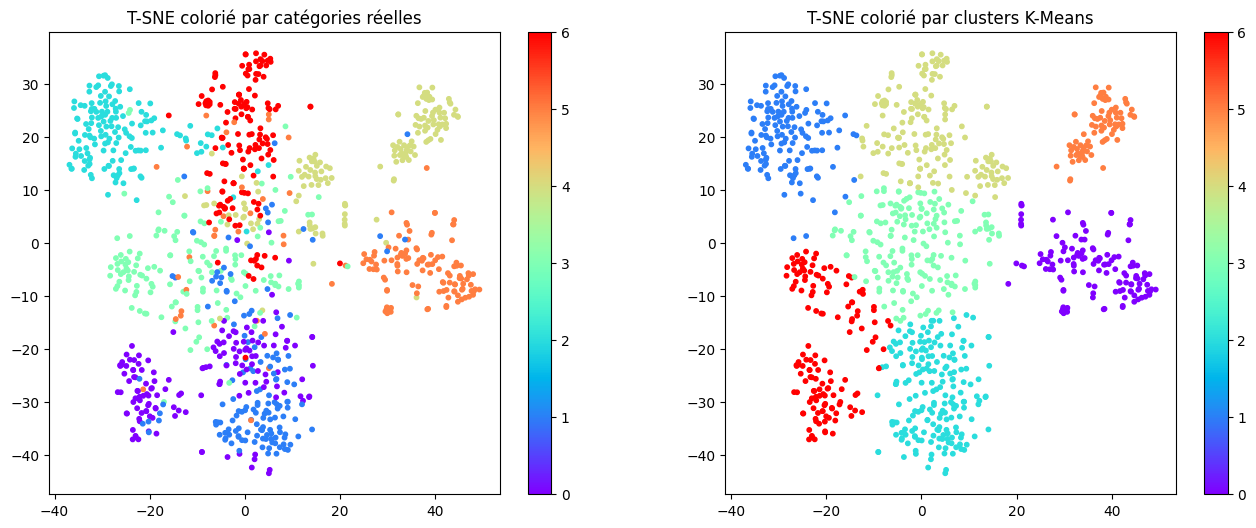

ARI Score : 0.45239560230268766


In [ ]:
# Appliquer T-SNE pour réduire les features à 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
features_tsne = tsne.fit_transform(features_pca)

# Mapper les catégories réelles à des valeurs numériques
unique_categories = df['cat_1'].unique()
category_map = {category: idx for idx, category in enumerate(unique_categories)}
labels_numeriques = df['cat_1'].map(category_map)

# Appliquer K-Means avec 7 clusters (nombre de catégories réelles)
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(features_tsne)

# Affichage des résultats
plt.figure(figsize=(16, 6))

# T-SNE colorié par catégories réelles
plt.subplot(1, 2, 1)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_numeriques, cmap='rainbow', s=10)
plt.title("T-SNE colorié par catégories réelles")
plt.colorbar()

# T-SNE colorié par clusters K-Means
plt.subplot(1, 2, 2)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=clusters, cmap='rainbow', s=10)
plt.title("T-SNE colorié par clusters K-Means")
plt.colorbar()

plt.show()

# Calcul de l'ARI pour mesurer la qualité du clustering
ari_score = adjusted_rand_score(labels_numeriques, clusters)
print(f"ARI Score : {ari_score}")

## <font color='red'>5. Conclusion</font><a class="anchor" id="partie5"></a>

L'utilisation du modèle VGG16 avec transfer learning pour la classification automatique des images a montré des résultats nettement meilleurs que ceux obtenus avec la méthode SIFT. En appliquant le T-SNE pour la réduction de dimension et K-Means pour le clustering, la séparation des catégories est plus distincte visuellement, et les clusters semblent mieux capturer les différences entre les classes de produits.

Le score Adjusted Rand Index (ARI) de 0.452 reflète une amélioration significative par rapport à la méthode SIFT (ARI = 0.003). Bien que ce score indique encore une marge d'amélioration possible, il montre que le modèle VGG16 est capable de capturer des caractéristiques pertinentes dans les images pour une classification partiellement efficace.

Les résultats de ce modèle montrent que les réseaux de neurones convolutionnels pré-entraînés, tels que VGG16, permettent d'extraire des features plus puissants et discriminants que les descripteurs manuels comme ceux de SIFT. Cependant, des optimisations supplémentaires, telles que la data augmentation et l'optimisation des hyperparamètres, pourraient encore améliorer la précision de cette classification.